<a href="https://colab.research.google.com/github/Zumbergz/Team2Project/blob/main/GMITTeam2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tweepy
import requests
import regex as re

In [4]:
# get data fron the csv files in the github repo
# return as csv using panda

github_data_url = "https://raw.githubusercontent.com/Zumbergz/Team2Project/main/data/"
file_ext = ".csv"

def get_data(file_name, flip):
  data = pd.read_csv(github_data_url + file_name + file_ext)
  if flip:
    return data.iloc[::-1]
  return data

In [38]:
# Get data for covid and other indices
covid_data = get_data("daily_cases", False)
asia_data = get_data("asia_dow", True)
ftse_data = get_data("ftse", True)
nasdaq_data = get_data("nasdaq", True)
sp_data = get_data("sp500", True)

In [6]:
# maps of all the stock indices

index_countries = {
    "asia": ["Japan", "Australia", "China", "Hong Kong", "Korea (South)", "Taiwan", "India", "Indonesia", "Malaysia", "Singapore"],
    "ftse": ["United Kingdom"],
    "nasdaq": [],
    "sp": ["United States of America"]
}

index_dataset = {
    "asia": asia_data,
    "ftse": ftse_data,
    "nasdaq": nasdaq_data,
    "sp": sp_data
}

index_names = {
    "asia": "Asia Dow",
    "ftse": "FTSE 100",
    "nasdaq": "NASDAQ",
    "sp": "S&P 500"
}

In [7]:
# gets the cases for a list of countries
def cases_per_countries(countries):
  # return full list if no countries specified
  if countries == []:
    countries = set(covid_data["Country"])

  temp = covid_data
  # adds covid data to new list for specific countries
  country_data = []
  for country in countries:
    country_data.append(temp.loc[temp["Country"] == country])
  return country_data


In [8]:
# Make figures appear larger in notebook
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
def create_plot(data, countries, name):
  #Add stlye to plot and set up custom x markers
  plt.style.use('ggplot')
  my_xticks = ['06/18','00/19','06/19','00/20', '06/20', '00/21', '06/21']
  length = len(data["Date"])
  # Spread 7 markers evenly across axis
  x_pos = np.arange(0,length+1,length/(len(my_xticks)-1))
  stocks_data, = plt.plot(np.arange(0,len(data)),data["Open"], 'g', label = name + " Index")
  plt.xlabel("Date")
  plt.ylabel("Price ($)")
  plt.twinx()
  plt.xticks(x_pos, my_xticks)
  # Plot case data alongside index data
  case_data, = plt.plot(np.arange(0,len(countries)), countries["New"], 'r', label  = "Covid Cases")
  plt.ylabel("No. of Coronavirus cases Daily")
  plt.title("Coronavirus Cases vs Value of the {} Index".format(name))
  plt.legend(handles=[stocks_data, case_data], bbox_to_anchor=(1.1,0.95), loc='upper left', borderaxespad=0.)
  plt.show()

In [9]:
pd.options.mode.chained_assignment = None
def combine_country_cases(countries):
  # Reset index for consistency
  summing = countries[0].reset_index(drop=True)
  # Sum with all other countries to combine cases
  for i in range(1, len(countries),1 ):
    current = countries[i].reset_index(drop=True)
    sum_column = summing["New"].add(current["New"], fill_value=0)
    summing["New"] = sum_column
  return summing

In [10]:
def pad_covid_data(case_data, stock_data):
  # Fix length of case data by adding 0s to fill dates before pandemic
  dif = len(stock_data) - len(case_data)
  case_data = case_data.iloc[::-1]
  padding = pd.DataFrame(np.zeros((dif, len(case_data.columns))), columns=case_data.columns)
  padding["Date"] = stock_data.reset_index(drop=True)["Date"]
  padding["Country"] = case_data["Country"][0]
  case_data = case_data.append(padding)
  case_data = case_data.iloc[::-1].reset_index(drop=True)
  return case_data

In [11]:
#gets the data between specific dates
def cut_between_dates(data, start_date, end_date, date_format):
  data[date_format] = pd.to_datetime(data[date_format])
  date_filter = (data[date_format] >= start_date) & (data[date_format] <= end_date)
  data = data.loc[date_filter]
  return data

In [12]:
#gets the average sentiment score per day and creates a new data frame that has a Date and a sentiment
def get_sentiment_probability_daily(data, days):
  mean_tweets_vals = pd.DataFrame(columns = ["sentimentProbability", "Date"])
  setiments_list = []
  dates_list = []

  for i in range(len(days)-1):
    daily_data = cut_between_dates(twitter_data,days[i], days[i+1],"created_at")
    setiments_list.append(daily_data["sentimentProbability"].mean())
    dates_list.append(days[i])

  mean_tweets_vals["sentimentProbability"] = setiments_list
  mean_tweets_vals["Date"] = dates_list

  return mean_tweets_vals

In [13]:
#gets the average sentiment score per day and creates a new data frame that has a Date and a sentiment
def get_average_sentiment_daily_2(data, days):
  mean_tweets_vals = pd.DataFrame(columns = ["negative_sentiments","positive_sentiments", "Date"])
  dates_list = []
  negative_sentiments_list = []
  positive_sentiments_list = []

  for i in range(len(days)-1):
    daily_data = cut_between_dates(twitter_data,days[i], days[i+1],"created_at")
    negative_sentiments = 0
    positive_sentiments = 0

    length = len(daily_data["sentiment"])
    for sentiment in daily_data["sentiment"]:
      if sentiment == "NEGATIVE":
        negative_sentiments +=1
      else:
        positive_sentiments +=1
    
    negative_sentiments_list.append(negative_sentiments/length)
    positive_sentiments_list.append(positive_sentiments/length)
    dates_list.append(days[i])

  mean_tweets_vals["negative_sentiments"] = negative_sentiments_list
  mean_tweets_vals["positive_sentiments"] = positive_sentiments_list
  mean_tweets_vals["Date"] = dates_list

  return mean_tweets_vals

In [35]:
def create_covid_plot(stock_data, twitter_data):
  plt.style.use('ggplot')
  fig,ax1 = plt.subplots()
  ax1.set_xlabel("Date")
  ax1.set_ylabel("Negative Sentiments (%)")
  sentiments, = ax1.plot(twitter_data["Date"], twitter_data["negative_sentiments"], ".", label = "Negative Sentiments")

  dates = np.arange(0, len(twitter_data))
  m,b = np.polyfit(dates, twitter_data["negative_sentiments"],1)
  best_fit, = plt.plot(dates, m * dates + b, "black", linewidth=2.5, label = "Sentiment Trend")

  plt.xticks(rotation='vertical')
  ax2 = ax1.twinx()
  ax2.set_ylabel("Close Value of S&P 500 ($)")
  sp_prices, = ax2.plot(twitter_data["Date"], stock_data[" Close"], "b", label = "S&P 500 Price")
  plt.title("Percentage of Tweets with Negative Sentiment vs Price of the S&P 500 Index")
  plt.legend(handles=[sentiments, best_fit, sp_prices])
  fig.tight_layout() 
  
  plt.show()

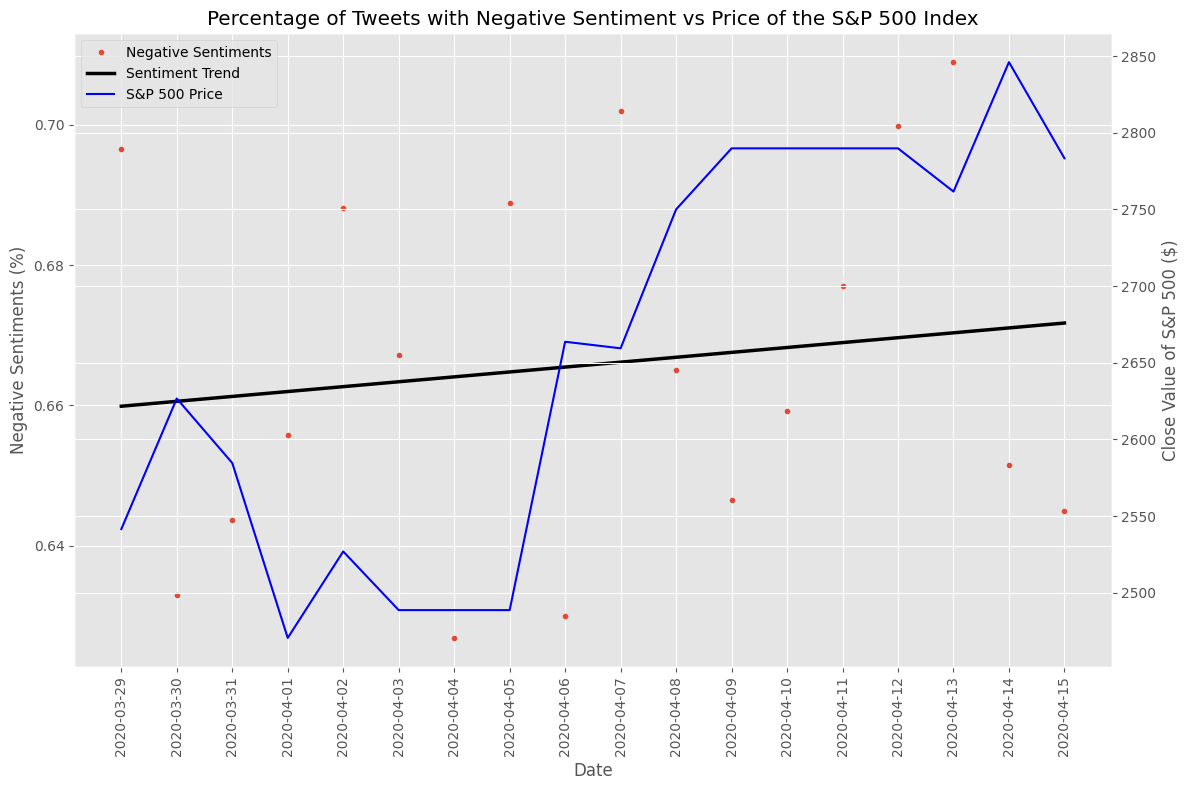

In [36]:
#the twitter data
twitter_data = get_data("AnalysedSentiments", True)

#s&p 500 data 
sp500_data = get_data("SP50029Mar-15Apr", False)

days = ["2020-03-29",
        "2020-03-30",
        "2020-03-31",
        "2020-04-01",
        "2020-04-02",
        "2020-04-03",
        "2020-04-04",
        "2020-04-05",
        "2020-04-06",
        "2020-04-07",
        "2020-04-08",
        "2020-04-09",
        "2020-04-10",
        "2020-04-11",
        "2020-04-12",
        "2020-04-13",
        "2020-04-14",
        "2020-04-15",
        "2020-04-16"]

final_twitter_data = get_average_sentiment_daily_2(twitter_data, days)
final_twitter_data.to_csv("twitter_data.csv", index=False)

#create the plot showing the relationship bewteen the covid tweets and the stock market index
create_covid_plot(sp500_data, final_twitter_data)

In [ ]:
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
print(sp500_data)

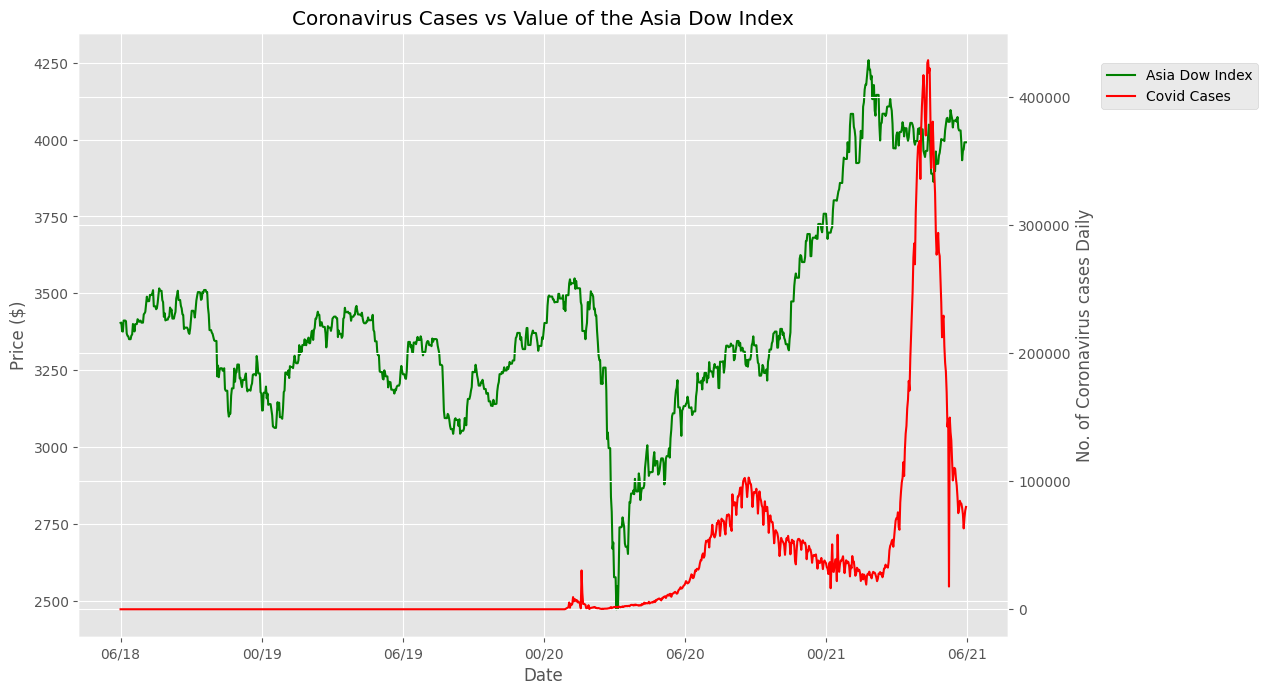

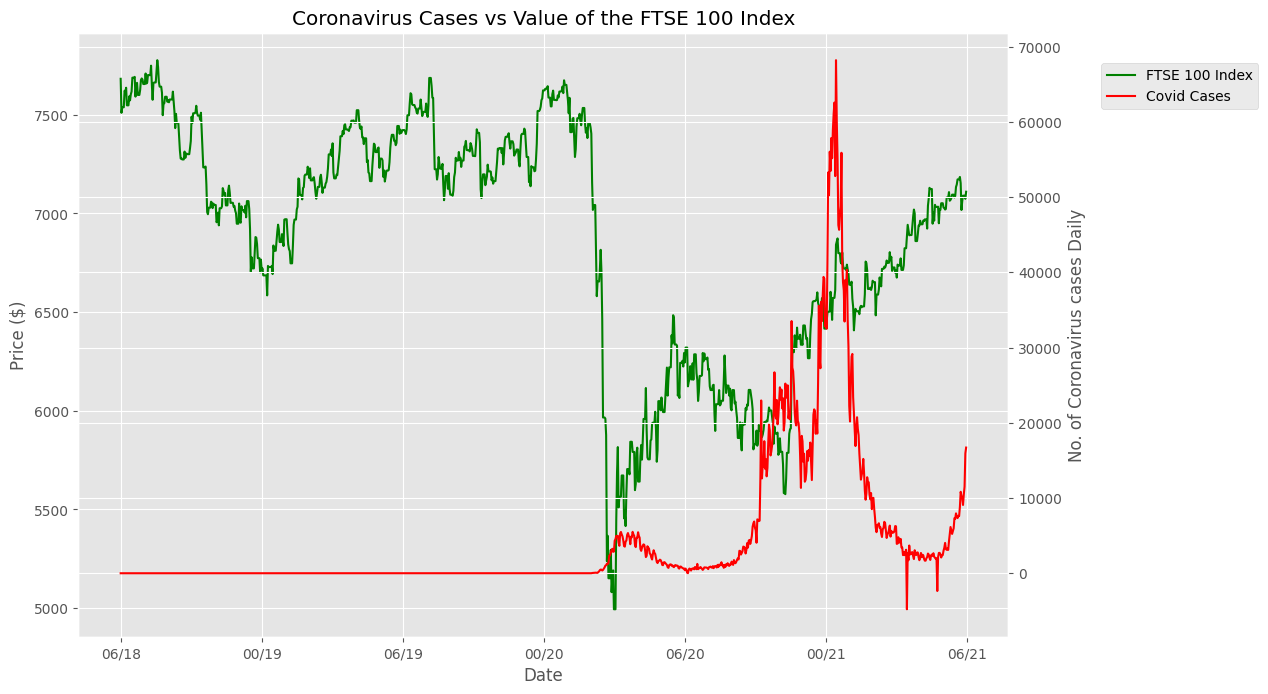

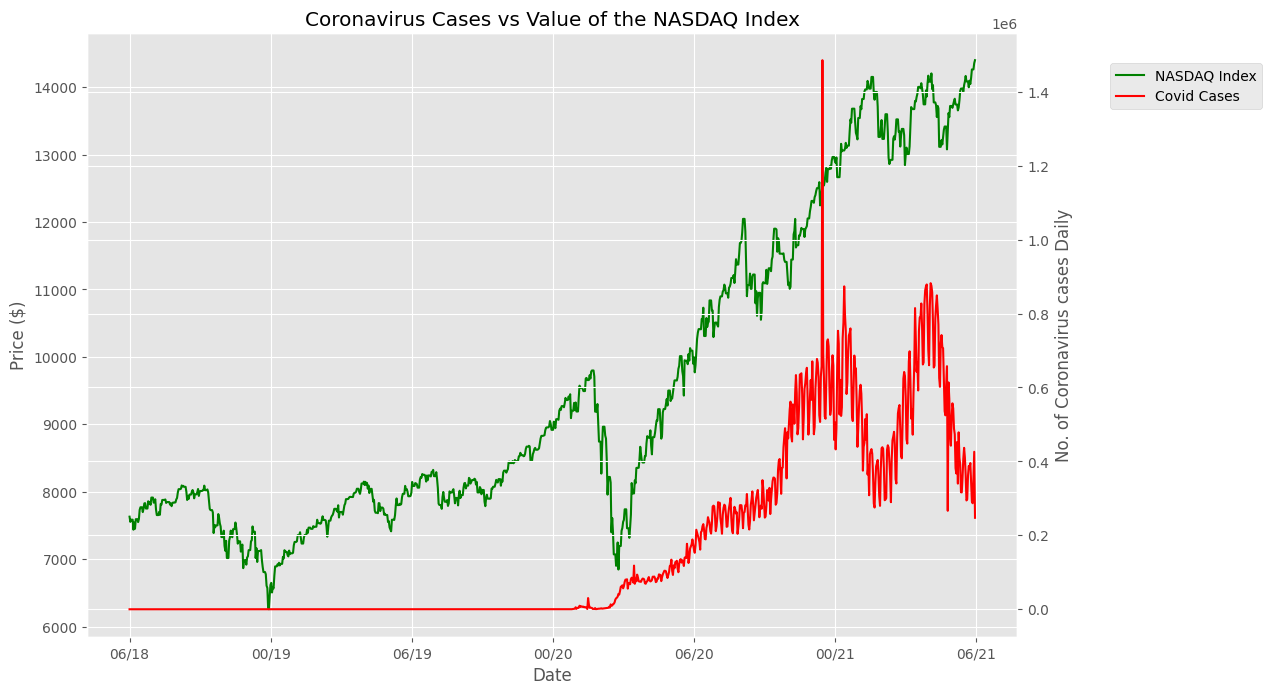

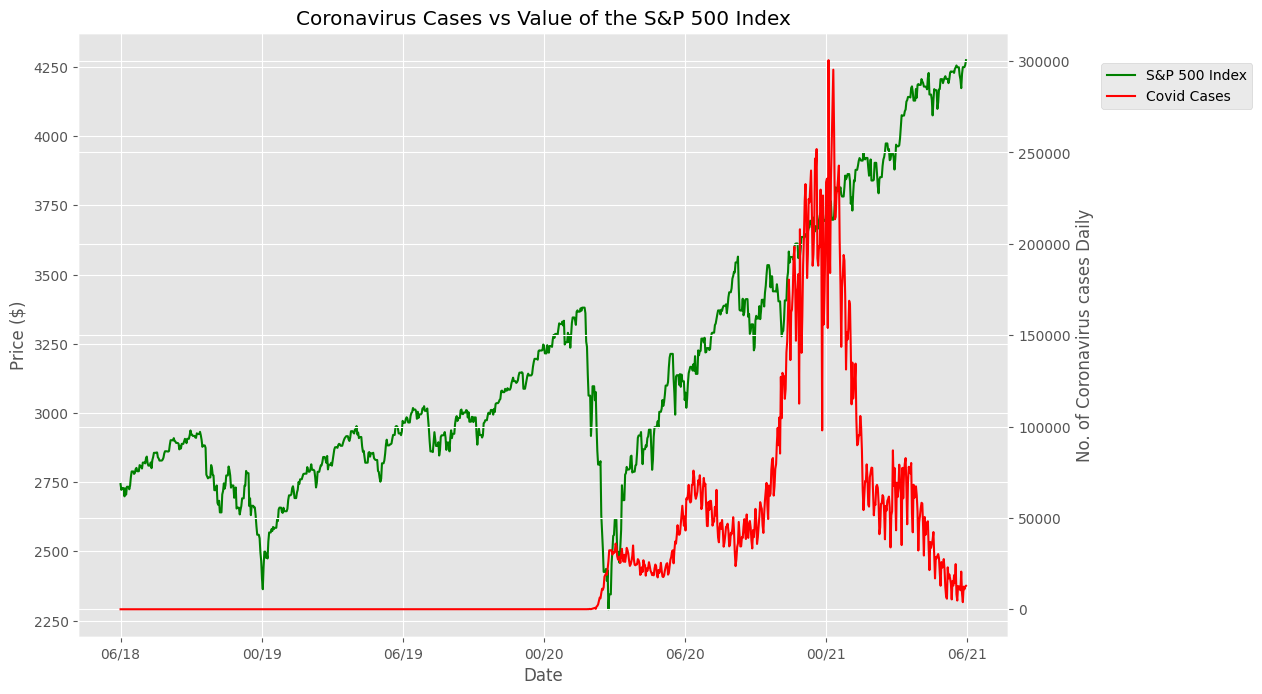

In [37]:
# loops all index data and creates index/covid cases graphs
combined_data = pd.DataFrame(data=None, columns=["asia", "ftse", "nasdaq", "sp", "Cases"])
for key, value in index_countries.items():
  countries = cases_per_countries(value)
  combined_country_data = combine_country_cases(countries)
  final_covid_data = pad_covid_data(combined_country_data, index_dataset[key])
  # Gets data from all countries for combined covid data
  if key == "nasdaq":
    combined_data["Cases"] = final_covid_data["New"]
  combined_data[key] = index_dataset[key]["Close"]
  create_plot(index_dataset[key], final_covid_data, index_names[key])

In [39]:
combined_data = combined_data.reindex(index=combined_data.index[::-1])
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(combined_data)

In [40]:
combined_data = combined_data[0:1064]

In [41]:
cases = combined_data["Cases"]
# Set up combined data
cases = np.flip(cases)
combined_data = combined_data.iloc[::-1].reset_index(drop=True)
combined_data["Cases"] = cases
print(combined_data)

         asia     ftse    nasdaq       sp     Cases
0     3431.74  7626.33   7855.12  2723.06       0.0
1     3434.92  7626.33   7854.44  2699.63       0.0
2     3437.53  7626.33   7825.30  2699.63       0.0
3     3465.28  7676.28   7820.20  2699.63       0.0
4     3488.29  7683.97   7841.87  2716.31       0.0
...       ...      ...       ...      ...       ...
1059  3971.45  7074.06  14271.73  4241.84  488943.0
1060  3976.41  7074.06  14271.73  4241.84  473306.0
1061  4006.67  7074.06  14271.73  4241.84  381817.0
1062  4006.67  7109.97  14369.71  4266.49  367286.0
1063  4006.67  7136.07  14360.39  4280.70  452503.0

[1064 rows x 5 columns]


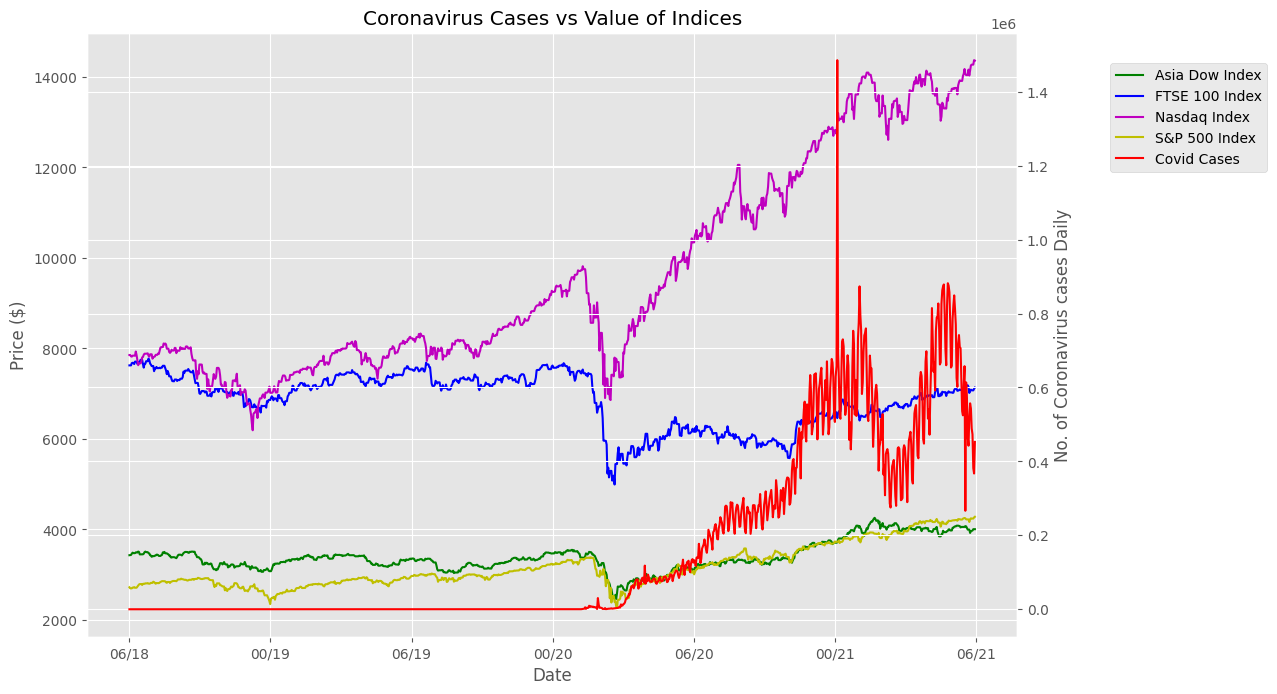

In [42]:
# Creating combined plot
plt.style.use('ggplot')
my_xticks = ['06/18','00/19','06/19','00/20', '06/20', '00/21', '06/21']
length = len(combined_data["asia"])
x_pos = np.arange(0,length+1,length/(len(my_xticks)-1))
# Plot for all indices
asia_data_graph, = plt.plot(np.arange(0,len(combined_data)),combined_data["asia"], 'g', label ="Asia Dow Index")
ftse_data_graph, = plt.plot(np.arange(0,len(combined_data)),combined_data["ftse"], 'b', label = "FTSE 100 Index")
nasdaq_data_graph, = plt.plot(np.arange(0,len(combined_data)),combined_data["nasdaq"], 'm', label = "Nasdaq Index")
sp_data_graph, = plt.plot(np.arange(0,len(combined_data)),combined_data["sp"], 'y', label = "S&P 500 Index")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.twinx()
plt.xticks(x_pos, my_xticks)
case_data_graph, = plt.plot(np.arange(0,len(combined_data)), combined_data["Cases"], 'r', label  = "Covid Cases")
plt.ylabel("No. of Coronavirus cases Daily")
plt.title("Coronavirus Cases vs Value of Indices")
plt.legend(handles=[asia_data_graph, ftse_data_graph, nasdaq_data_graph, sp_data_graph, case_data_graph], bbox_to_anchor=(1.1,0.95), loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:
import csv
import requests
from time import sleep

In [ ]:
# Set up stock request and name arrays for all stocks
stock_requests = ["https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=CPER&outputsize=full&apikey={}&datatype=csv".format(alpha_key),
                  "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=ASM&outputsize=full&apikey={}&datatype=csv".format(alpha_key),
                  "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=DAL&outputsize=full&apikey={}&datatype=csv".format(alpha_key),
                  "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=CEA&outputsize=full&apikey={}&datatype=csv".format(alpha_key),
                  "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=AMZN&outputsize=full&apikey={}&datatype=csv".format(alpha_key),
                  "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=FB&outputsize=full&apikey={}&datatype=csv".format(alpha_key),
                  "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=HLT&outputsize=full&apikey={}&datatype=csv".format(alpha_key),
                  "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IHG&outputsize=full&apikey={}&datatype=csv".format(alpha_key),
                  "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=PFE&outputsize=full&apikey={}&datatype=csv".format(alpha_key),
                  "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=AZN&outputsize=full&apikey={}&datatype=csv".format(alpha_key),
                  "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=USO&outputsize=full&apikey={}&datatype=csv".format(alpha_key),
                  "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=UGA&outputsize=full&apikey={}&datatype=csv".format(alpha_key),
                  "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=JPM&outputsize=full&apikey={}&datatype=csv".format(alpha_key),
                  "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MS&outputsize=full&apikey={}&datatype=csv".format(alpha_key),

]

                  
stock_name = ["USCopper Index Fund",
"Avino Silver & Gold Mines",
"Delta Air Lines",
"China Eastern Airlines",
"Amazon.com, Inc.",
"Facebook, Inc.",
"Hilton Worldwide Holding.",
"IHG American Depositary Shares",
"Pfizer.",
"Astrazeneca",
"US Oil",
"US Gasoline",
"JP Morgan Chase & Co.",
"Morgan Stanley"
]

stock_data = []


In [ ]:
# Loop through all requests and get data from the AlphaVantage API
count = 0
for url in stock_requests:
  count += 1
  with requests.Session() as s:
    if count > 5:
      # Sleep every 5 requests to avoid API timeout
      sleep(65)
      count = 1
    download = s.get(url)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    data = pd.DataFrame(list(cr))
    stock_data.append(data)
  

In [ ]:
for k,row in enumerate(stock_data):
   # Reset header for each data fetched
   new_header = row.iloc[0] 
   row = row[1:] 
   row.columns = new_header 
   stock_data[k] = row

In [ ]:
print(stock_data[0].columns)

In [ ]:
cut_data = []
for data in stock_data:
  # Normalise data so all stock data begins and ends at the same date
  cut = data[2:773]
  cut = cut.iloc[::-1]
  cut = cut.reset_index(drop=True)
  cut_data.append(cut)

cut_data

In [ ]:
split_1 = 193  # Pre-Covid
split_2 = 400  # News begins, covid beginning
split_3 = 565  # During Covid

In [ ]:
def get_percentage_returns(stock):
  # Get percentage returns from different phases by calculating percentage change
  start_val = stock["close"][0]
  split_1_val = stock["close"][split_1]
  split_2_val = stock["close"][split_2]
  split_3_val = stock["close"][split_3]
  final_val = stock["close"][len(stock)-1]
  perc_1 = calc_perc_change(start_val, split_1_val)
  perc_2 = calc_perc_change(split_1_val, split_2_val)
  perc_3 = calc_perc_change(split_2_val, split_3_val)
  perc_4 = calc_perc_change(split_3_val, final_val)
  total_perc = calc_perc_change(start_val, final_val)
  return [perc_1, perc_2, perc_3, perc_4, total_perc]

def calc_perc_change(x, y):
  return (float(y) - float(x))/float(x) * 100

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

def create_percent_plot(data_1, data_2, data_3, data_4, final_data, company_names):
  # Plot data in bar graph
  plt.style.use('ggplot')
  ax = plt.subplot(111)
  w = 1
  x = np.arange(1,len(data_1)*4, 4)
  ax.bar(x-w,data_1, width=w/2, color='b', align='center', label='Phase 1')
  ax.bar(x-w/2, data_2, width=w/2, color='g', align='center', label='Phase 2')
  ax.bar(x, data_3, width=w/2, color='y', align='center', label='Phase 3')
  ax.bar(x+w/2, data_4, width=w/2, color='c', align='center', label='Phase 4')
  ax.bar(x+w, final_data, width=w/2, color='m', align='center', label='Total')
  plt.xticks(x, company_names, rotation='vertical')
  plt.title("Value Shifts of Shares During Different Phases of the Coronavirus Pandemic")
  plt.ylabel("Value Shift (%)")
  plt.legend()


data_1 = []
data_2 = []
data_3 = []
data_4 = []
final_data =[]
for stock in cut_data:
  # Get percentage returns for each stock and build arrays to be used in plotting
  perc_data = get_percentage_returns(stock)
  data_1.append(perc_data[0])
  data_2.append(perc_data[1])
  data_3.append(perc_data[2])
  data_4.append(perc_data[3])
  final_data.append(perc_data[4])
create_percent_plot(data_1, data_2, data_3, data_4, final_data, stock_name)

